In [259]:
%matplotlib inline

from __future__ import division, print_function

import copy
from functools import partial
import itertools as it
import math

import affine
import fiona as fio
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio as rio
from rasterio.plot import show
from rasterio.features import rasterize, shapes
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from shapely import geometry

In [45]:
with fio.open('shoredist/gshhg-shp-2.3.5-1/GSHHS_shp/f/GSHHS_f_L1.shp') as src:
    feat = src[379]
    geom = geometry.shape(feat['geometry'])

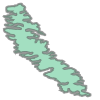

In [12]:
geom

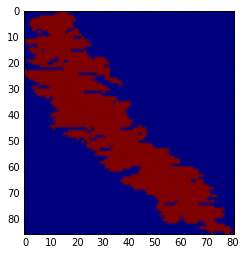

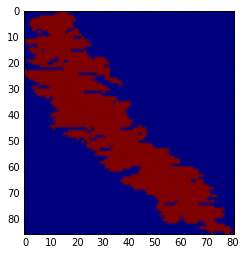

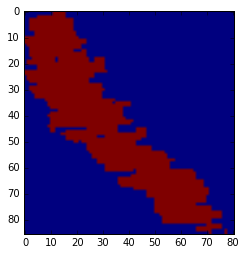

In [310]:
xmin, ymin, xmax, ymax = geom.bounds

xres = yres = 0.007

height = int(math.ceil((ymax - ymin) / xres))
width = int(math.ceil((xmax - xmin) / xres))

aff = affine.Affine(xres, 0.0, xmin,
                    0.0, -yres, ymax)

# lxres = xres * 10
# lyres = yres * 10
lxres = xres * 1
lyres = yres * 1
lheight = int(math.ceil((ymax - ymin) / lxres))
lwidth = int(math.ceil((xmax - xmin) / lxres))


laff = affine.Affine(lxres, 0.0, xmin,
                     0.0, -lyres, ymax)

rize = rasterize(
    shapes=[geom],
    out_shape=(height, width),
    dtype=rio.ubyte,
    transform=aff,
    fill=0,
    default_value=1)

show(rize)

low_res = rasterize(
    shapes=[geom],
    out_shape=(lheight, lwidth),
    dtype=rio.ubyte,
    transform=laff,
    fill=0,
    default_value=1)

show(low_res)


rize = rasterize(
    shapes=shapes(low_res, transform=laff),
    out=rize,
    all_touched=True,
    transform=aff)


show(rize)

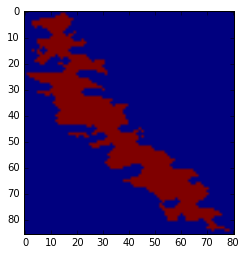

In [311]:
eroded = binary_erosion(low_res)
show(eroded)

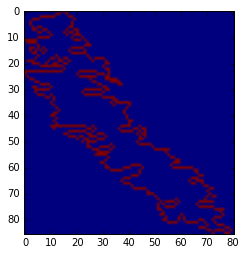

In [312]:
edges = (low_res ^ eroded).astype(rio.ubyte)
show(edges)

In [313]:
geod = pyproj.Geod(ellps='WGS84')


# Y offset is negative
half_pixel_offset = np.array([lxres / 2, -(lyres / 2)], dtype=np.float32)


# Need to drop affine.Affine() and brew our own numpy-based solution
def index2xy(idx):
    return reversed(idx) * aff


def lindex2xy(idx):
    return reversed(idx) * laff


water_pixels = (~(rize.astype(np.bool))).astype(np.ubyte)

edge_pixels = np.vstack(np.nonzero(edges)).transpose()
water_pixels = np.vstack(np.nonzero(water_pixels)).transpose()

edge_coords = np.apply_along_axis(lindex2xy, 1, edge_pixels)
water_coords = np.apply_along_axis(index2xy, 1, water_pixels)

edge_coords += half_pixel_offset
water_coords += half_pixel_offset

In [314]:
# coords = sorted(map(tuple, edge_coords))
# xs = [p[0] for p in coords]
# ys = [p[1] for p in coords]

# plt.scatter(xs, ys)

In [315]:
def dist(pixel_xy, ecoords):
    
    coords = ecoords.transpose()
    
    lons2 = coords[0]
    lats2 = coords[1]
    
    lons1 = np.empty(lons2.shape)
    lons1.fill(pixel_xy[0])
    
    lats1 = np.empty(lats2.shape)
    lats1.fill(pixel_xy[1])
    
    return geod.inv(lons1=lons1, lats1=lats1, lons2=lons2, lats2=lats2)[2]

line_geoms = []
out = np.zeros(rize.shape, np.float32)
for widx, wpair in enumerate(water_coords):
    distances = dist(wpair, edge_coords)
    nx, ny = edge_coords[np.argmin(distances)]
    row, col = water_pixels[widx]
    out[row][col] = distances.min().item()
    
    line_geoms.append({
            'type': 'LineString',
            'coordinates': ((nx, ny), (wpair[0], wpair[1]))
        })

In [316]:
profile = {
    'crs': 'EPSG:4326',
    'width': width,
    'height': height,
    'dtype': edges.dtype,
    'count': 1,
    'nodata': 0,
    'driver': 'GTiff',
    'transform': aff
}

lprofile = profile.copy()
lprofile.update(width=lwidth, height=lheight, transform=laff)

with rio.open('RIZE.tif', 'w', **profile) as dst:
    dst.write(rize.astype(rio.ubyte), indexes=1)
with rio.open('LOW-RES.tif', 'w', **lprofile) as dst:
    dst.write(low_res.astype(rio.ubyte), indexes=1)
with rio.open('EDGES.tif', 'w', **profile) as dst:
    dst.write(edges.astype(rio.ubyte), indexes=1)
with rio.open('ERODED.tif', 'w', **profile) as dst:
    dst.write(eroded.astype(rio.ubyte), indexes=1)
profile = profile.copy()
profile.update(dtype=np.float32, nodata=-9999)
with rio.open('OUT.tif', 'w', **profile) as dst:
    dst.write(out, indexes=1)

In [317]:
profile = {
    'crs': 'EPSG:4326',
    'schema': {
        'geometry': 'Point',
        'properties': {}
    },
    'driver': 'ESRI Shapefile'
}


with fio.open('EDGES.shp', 'w', **profile) as dst:
    for x, y in edge_coords:
        dst.write({
                'type': 'Feature',
                'properties': {},
                'geometry': {
                    'type': 'Point',
                    'coordinates': (x, y)
                }
            })


profile = copy.deepcopy(profile)
profile['schema'].update(geometry='LineString')


with fio.open('LINES.shp', 'w', **profile) as dst:
    for g in line_geoms:
        dst.write({
            'type': 'Feature',
            'properties': {},
            'geometry': g
        })